# Comparing Class Weights vs Undersampling to Handle Imbalanced Data

In this data set we wish to train a logistic model to detect credit card fraud. Since the data has mostly been handled by performing a PCA, there is no real cleaning/feature engineering required, so we instead choose to focus on two different methodoligies for handling imbalanced data. 

Imbalanced data occurs when one condition is more prevelant than the other. In this data set of credit card transactions, the vast majority of transactions are legitimate, while less than one percent are fradulent. Training a model without making adjustments would lead to poor performance, leading to many false flags for legitimate transactions allowing fradulent transactions to slip by. We will be examining several methods to conduct this detection of fradulent transactions and determining which appears to be the best methood based by using an F2 score. 

## loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, matthews_corrcoef, fbeta_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler, CondensedNearestNeighbour
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import gaussian_kde
import time

import math
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

## Loading Data

In [2]:
df= pd.read_csv("creditcard.csv")

## Examining the Data


We are examining the data to see if there are any issues or any feature engineering we might need to do. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
#sns.pairplot(df, hue='Class')

In [6]:
df.drop_duplicates(keep='first', inplace=True)

In [7]:
#sns.pairplot(df, x_vars=['Time'])



xy = np.vstack([df['Time'],df['Class']])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(df['Time'], df['Class'], c=z, s=100)
plt.show()

In [8]:
def time_fix(x):
    if x>=86400:
        return x-86400
    else: 
        return x
        

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


Time may play an important role in determining if the activity was fradulent. We want to compare the time data to the fraud cases and see if there is a more common time that fraud tends to happen.

<AxesSubplot:xlabel='Time', ylabel='Count'>

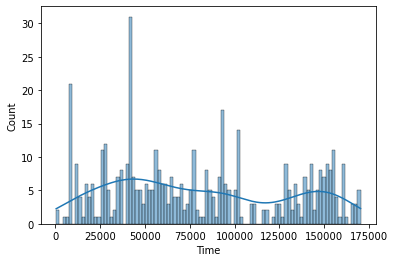

In [10]:
xfraud=df['Time'][df['Class']==1]
xnofraud=df['Time'][df['Class']==0]
sns.histplot(xfraud, bins=96, kde=True)


In [11]:
df['Time_Fix']=df['Time'].apply(lambda x: time_fix(x) )

<AxesSubplot:xlabel='Time_Fix', ylabel='Count'>

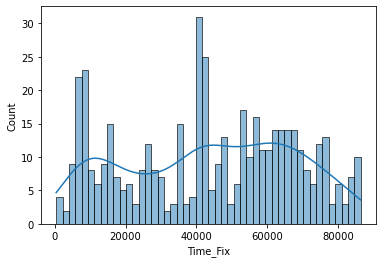

In [12]:

xfraud=df['Time_Fix'][df['Class']==1]
xnofraud=df['Time_Fix'][df['Class']==0]
sns.histplot(xfraud, bins=48, kde=True)

We were hoping to see some obvious sinusoidal pattern but that doesn't appear to be the case. 

In [13]:
#sns.histplot(xnofraud, bins=48, kde = True)

## Splitting the Data into Training and Testing sets

In [14]:
X=df.drop(['Class', 'Time'], axis = 1)
y=df['Class']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=42)

In [15]:
y_test.value_counts()

0    84984
1      134
Name: Class, dtype: int64

## Functions written to assist with displaying data and defining our metric.


This custom scorer will be used for cross validation later on in the process.

In [16]:
ftwo_scorer =  make_scorer(fbeta_score, beta=2)

This function displays the results of our classification and stores the values we are interested in for comparison at the end of the notebook. 

In [119]:
def classresults(pred, trueval):
    #print(classification_report(trueval, pred))
    
    #print(f'Accuracy Score: {accuracy_score(trueval,pred)}')
    #print(f'Area Under Curve: {roc_auc_score(trueval, pred)}')
    print('\033[1m' + 'Results:')
    print('\033[0m' + f'Precision: {precision_score(trueval,pred)}')
    print(f'Recall: {recall_score(trueval,pred)}')
    print(f'f1 score: {f1_score(trueval,pred)}')
    #print(f'Matthews Correlation Coefficient: {matthews_corrcoef(trueval,pred)}')
    print(f'F2 score: {fbeta_score(trueval,pred, beta=2)}')
    print('Confusion Matrix:')
    print(confusion_matrix(trueval, pred))
    cm=confusion_matrix(trueval, pred)
    ts=np.hstack(cm)
    ts=np.append(ts,[recall_score(trueval,pred), precision_score(trueval,pred), f1_score(trueval,pred),fbeta_score(trueval,pred, beta =2)] )
    return ts

This function finds the threshold in order to reach a certain minimum recall from our model. 

In [105]:
def threshold_at_recall(clf, X, y, desired_recall):
    
    precision_, recall_, thresholds_ = precision_recall_curve(y, clf.predict_proba(X)[:,1])
   
    return thresholds_[(recall_ > desired_recall).sum()-1]

This function runs a cross validation on the fitted models with the training data to get an estimate of it's performance. 

In [19]:
def croscor(model, X_set, y_set, scorer):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=101)
    t_start=time.time()
    score_temp = cross_val_score(model, X_set, y_set, scoring=scorer, cv=cv, n_jobs=-1)
    print(score_temp)
    print('Mean f2 score: %.3f' %score_temp.mean())
    t_stop= time.time()
    print("Elapsed time:", t_stop, t_start)
    print("Elapsed time during the whole program in seconds:",t_stop-t_start)    
    return score_temp.mean()

## Base Case: Random Forest Classification without any modifications.

In [20]:
rfc=RandomForestClassifier(n_jobs=16, random_state=42)
rfc.fit(X_train,y_train)
prediction1=rfc.predict(X_test)


In [21]:
threshold = threshold_at_recall(rfc, X_train, y_train, 0.9)

In [22]:
threshold

0.63

In [97]:
classresults(rfc.predict_proba(X_test)[:,1]>=threshold, y_test)

[[84980     4]
 [   41    93]]
Precision: 0.9587628865979382
Recall: 0.6940298507462687
f1 score: 0.8051948051948052
F2 score: 0.7345971563981042


array([8.49800000e+04, 4.00000000e+00, 4.10000000e+01, 9.30000000e+01,
       6.94029851e-01, 9.58762887e-01, 8.05194805e-01, 7.34597156e-01])

In [112]:
ts1=classresults(prediction1,y_test)

Here are the results:
Precision: 0.9509803921568627
Recall: 0.7238805970149254
f1 score: 0.8220338983050848
F2 score: 0.7601880877742948
Confusion Matrix:
[[84979     5]
 [   37    97]]


In [25]:
croScore=[[]]

In [26]:
croScore.append(croscor(rfc, X_train, y_train, ftwo_scorer))

[0.73846154 0.77507599 0.85843373 0.83591331 0.85843373 0.82568807
 0.8        0.76452599 0.78947368 0.87087087 0.75384615 0.82066869
 0.81570997 0.80745342 0.85585586 0.82066869 0.75384615 0.80792683
 0.85365854 0.83333333]
Mean f2 score: 0.812
Elapsed time: 1660987004.1670237 1660986787.352903
Elapsed time during the whole program in seconds: 216.81412076950073


In [27]:
croScore.remove([])

# Applying Weights to model parameters

In [28]:
rfcw=RandomForestClassifier(n_jobs=16, random_state=42, class_weight = 'balanced_subsample')
rfcw.fit(X_train,y_train)
prediction2=rfcw.predict(X_test)

In [29]:
sum((rfcw.predict_proba(X_test)[:,1]>.95)==prediction2)

85034

In [113]:
ts2=classresults(prediction2,y_test)

Here are the results:
Precision: 0.9514563106796117
Recall: 0.7313432835820896
f1 score: 0.8270042194092827
F2 score: 0.7668231611893584
Confusion Matrix:
[[84979     5]
 [   36    98]]


In [31]:
croScore.append(croscor(rfcw, X_train,y_train, ftwo_scorer))

[0.74303406 0.75384615 0.82066869 0.77044025 0.81288344 0.78461538
 0.75851393 0.72755418 0.79192547 0.81039755 0.68965517 0.77160494
 0.79268293 0.8125     0.84337349 0.81288344 0.70532915 0.75384615
 0.85626911 0.79510703]
Mean f2 score: 0.780
Elapsed time: 1660987142.1482487 1660987014.7280521
Elapsed time during the whole program in seconds: 127.42019653320312


# Undersampling

Here we will use the __Edited Nearest Neighbors__ Sampler to help with the class imbalance in the data set. 

In [33]:
y_train.value_counts()

0    198269
1       339
Name: Class, dtype: int64

In [34]:
t1_start =time.time()

enn = EditedNearestNeighbours(n_jobs =16)
X_enn, y_enn = enn.fit_resample(X_train, y_train)

t1_stop = time.time()
   
print("Elapsed time:", t1_stop, t1_start)
   
print("Elapsed time during the whole program in seconds:",
                                            t1_stop-t1_start) 



Elapsed time: 1660988011.0127773 1660987142.1972046
Elapsed time during the whole program in seconds: 868.8155727386475


In [35]:
print(sorted(Counter(y_enn).items()))

[(0, 198002), (1, 339)]


Note here that actually the imbalance was not helped very much, so we will probably not see any major changes in the results. I suspect this maybe because the data set shows no clear boundary between our fraud and non-fraud cases.

In [36]:
rfcenn=RandomForestClassifier(n_jobs=16, random_state=101)
rfcenn.fit(X_enn,y_enn)
prediction3=rfcenn.predict(X_test)

In [114]:
ts3=classresults(prediction3,y_test)

Here are the results:
Precision: 0.941747572815534
Recall: 0.7238805970149254
f1 score: 0.8185654008438819
F2 score: 0.7589984350547729
Confusion Matrix:
[[84978     6]
 [   37    97]]


In [38]:
croScore.append(croscor(rfcenn, X_enn, y_enn, ftwo_scorer))

[0.85106383 0.79439252 0.8030303  0.81818182 0.8        0.81570997
 0.75851393 0.81039755 0.80792683 0.83586626 0.80792683 0.84848485
 0.83586626 0.77272727 0.77639752 0.83081571 0.83076923 0.7957958
 0.82066869 0.77399381]
Mean f2 score: 0.809
Elapsed time: 1660988255.0533059 1660988026.7608068
Elapsed time during the whole program in seconds: 228.29249906539917


We can see that the performance is almost identical to our base case. 



Let's try a slightly different algorith, this time using the Condensed Nearest Neighbor method for undersampling. 

In [39]:
t2_start =time.time()
cnn=CondensedNearestNeighbour(random_state=42, n_jobs=-1)
X_cnn, y_cnn = cnn.fit_resample(X_train, y_train)
t2_stop = time.time()
   
print("Elapsed time:", t2_stop, t2_start)
   
print("Elapsed time during the whole program in seconds:",
                                            t2_stop-t2_start) 

print(sorted(Counter(y_cnn).items()))



Elapsed time: 1660998626.4011705 1660988255.07055
Elapsed time during the whole program in seconds: 10371.330620527267
[(0, 1702), (1, 339)]


In [40]:
rfcnn=RandomForestClassifier(n_jobs=16, random_state=101)
rfcnn.fit(X_cnn,y_cnn)
prediction4=rfcnn.predict(X_test)

In [115]:
ts4=classresults(prediction4,y_test)

Here are the results:
Precision: 0.5729166666666666
Recall: 0.8208955223880597
f1 score: 0.6748466257668712
F2 score: 0.7554945054945055
Confusion Matrix:
[[84902    82]
 [   24   110]]


In [42]:
croScore.append(croscor(rfcnn,X_cnn, y_cnn, ftwo_scorer))

[0.9439528  0.88414634 0.79510703 0.92814371 0.82568807 0.83841463
 0.89393939 0.96153846 0.80792683 0.87613293 0.88588589 0.82043344
 0.88855422 0.85106383 0.9375     0.86102719 0.83586626 0.87087087
 0.92814371 0.87613293]
Mean f2 score: 0.876
Elapsed time: 1660998629.3103702 1660998626.8253646
Elapsed time during the whole program in seconds: 2.4850056171417236


# Random Under Sampling

We will not attempt to force a stronger undersampling by using a random undersampler and setting it so that our sample is perfectly balanced instead. 

In [43]:
rus = RandomUnderSampler()
X_rus , y_rus = rus.fit_resample(X_train,y_train)
print(sorted(Counter(y_rus).items()))


[(0, 339), (1, 339)]


In [44]:
rfcrus=RandomForestClassifier(n_jobs=16, random_state=101)
rfcrus.fit(X_rus,y_rus)
prediction5=rfcrus.predict(X_test)

In [116]:
ts5=classresults(prediction5,y_test)

Here are the results:
Precision: 0.04490566037735849
Recall: 0.8880597014925373
f1 score: 0.08548850574712644
F2 score: 0.18675455116133083
Confusion Matrix:
[[82453  2531]
 [   15   119]]


In [46]:
croScore.append(croscor(rfcrus, X_rus, y_rus, ftwo_scorer))

[0.89820359 0.85106383 0.9375     0.93655589 0.94029851 0.92814371
 0.91317365 0.92920354 0.87692308 0.90361446 0.9347181  0.95238095
 0.92261905 0.85889571 0.91591592 0.92261905 0.89123867 0.91317365
 0.96096096 0.9375    ]
Mean f2 score: 0.916
Elapsed time: 1660998630.1063635 1660998629.727367
Elapsed time during the whole program in seconds: 0.3789966106414795


# Oversampling

In [47]:
sm=SMOTE(random_state=42, n_jobs=-1)


In [48]:
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [49]:
print(sorted(Counter(y_smote).items()))

[(0, 198269), (1, 198269)]


In [50]:
rfcsmote=RandomForestClassifier(n_jobs=16, random_state=101)
rfcsmote.fit(X_smote,y_smote)
prediction6=rfcsmote.predict(X_test)


In [117]:
ts6=classresults(prediction6,y_test)

Here are the results:
Precision: 0.8983050847457628
Recall: 0.7910447761194029
f1 score: 0.8412698412698412
F2 score: 0.8103975535168196
Confusion Matrix:
[[84972    12]
 [   28   106]]


In [52]:
croScore.append(croscor(rfcsmote, X_smote, y_smote, ftwo_scorer))

[0.9999647  0.99993948 0.99993948 0.99994452 0.9999647  0.99993948
 0.99995461 0.99994452 0.99995965 0.99994452 0.99994452 0.99992939
 0.99997478 0.99995965 0.99995461 0.99993948 0.99993444 0.9999647
 0.99994956 0.9999647 ]
Mean f2 score: 1.000
Elapsed time: 1660999109.084498 1660998657.9708
Elapsed time during the whole program in seconds: 451.11369800567627


# Combined Over and Under Sampling


In [53]:
t3_start=time.time()

                                            
sme=SMOTEENN(n_jobs=16)
X_sme, y_sme = sme.fit_resample(X_train,y_train)
t3_stop= time.time()
   
print("Elapsed time:", t3_stop, t3_start)
   
print("Elapsed time during the whole program in seconds:",t3_stop-t3_start) 


Elapsed time: 1661002370.5088992 1660999109.1034968
Elapsed time during the whole program in seconds: 3261.4054024219513


In [54]:
print(sorted(Counter(y_sme).items()))

[(0, 186689), (1, 193747)]


In [55]:
rfcsme=RandomForestClassifier(n_jobs=16, random_state=101)
rfcsme.fit(X_sme,y_sme)
prediction7=rfcsme.predict(X_test)

In [118]:
ts7=classresults(prediction7,y_test)

Here are the results:
Precision: 0.8677685950413223
Recall: 0.7835820895522388
f1 score: 0.8235294117647058
F2 score: 0.7990867579908678
Confusion Matrix:
[[84968    16]
 [   29   105]]


In [57]:
croScore.append(croscor(rfcsme, X_sme,y_sme, ftwo_scorer))

[0.99985033 0.9999329  0.99991742 0.99990194 0.99984    0.99994323
 0.99993807 0.99995871 0.99982967 0.99990194 0.99992258 0.99999484
 0.99986581 0.99992774 0.99992258 0.99995871 0.99987613 0.99996387
 0.99981419 0.99984516]
Mean f2 score: 1.000
Elapsed time: 1661002812.359789 1661002397.3496704
Elapsed time during the whole program in seconds: 415.01011848449707


## Comparing the different methods.

In [120]:
dfcm=pd.DataFrame([ts1, ts2, ts3, ts4, ts5, ts6, ts7])
dfcm=dfcm.assign(croScoref2 = croScore)
dfcm.columns = ['True Negative', 'False positive', 'False Negative','True Positive', 'Recall', 'Precision', 'F1 Score', 'F2 Score', 'Mean F2 CrosVal']
dfcm.rename(index = {0: 'No Modification', 1: 'Weighted', 2: 'Undersample ENN', 3: 'Undersample CNN', 4:'Random Undersample', 5:'SMOTE Over', 6:' Combined SMOTEEN'}, inplace= True)

In [121]:
dfcm

,True Negative,False positive,False Negative,True Positive,Recall,Precision,F1 Score,F2 Score,Mean F2 CrosVal
No Modification,84979.0,5.0,37.0,97.0,0.723881,0.950980,0.822034,0.760188,0.811992
Weighted,84979.0,5.0,36.0,98.0,0.731343,0.951456,0.827004,0.766823,0.780357
Undersample ENN,84978.0,6.0,37.0,97.0,0.723881,0.941748,0.818565,0.758998,0.809426
Undersample CNN,84902.0,82.0,24.0,110.0,0.820896,0.572917,0.674847,0.755495,0.875523
Random Undersample,82453.0,2531.0,15.0,119.0,0.888060,0.044906,0.085489,0.186755,0.916235
SMOTE Over,84972.0,12.0,28.0,106.0,0.791045,0.898305,0.841270,0.810398,0.999951
Combined SMOTEEN,84968.0,16.0,29.0,105.0,0.783582,0.867769,0.823529,0.799087,0.999905


### Discussion of primary metric

Commonly the F1 score is favored because of it's balanced weight of the recall and precision, from a mathematical perspective that would be favorable, however from a business perspective that doesn't make sense to value the two the same. For credit card fraud detection the recall is more important, since we want to make sure we catch as many cases of fraud as possible. However, because we don't want to waste time and resources verifying every transaction, it is also undesireable to have too small of a precision either. By using the F2 metric, we are placing more importance on the recall since that is more important from a business perspective. 

For the F2 score, the best performing methods are the SMOTE oversampling, and the Combined SMOTE and ENN. The scores are very close and the raw performance is almost identical, so the difference may come down to random sampling. In this data set, SMOTE has the better recall and precision than the SMOTEEN case, where as many of the other methods we see trade offs, with no sampling applied having higher precision, but lower recall, and undersampling methods have higher recall but lower precision. The exception to this is the ENN method, but that is likely because the amount of undersampling done was very minimal, the data set shrunk by less than 1%, which means the data set behaves more or less identical to the none-resampled models. 

#### Using different testing splits to compare SMOTE and SMOTEEN performance

As mentioned previously we believe the two sampling methods produce comparable results. In the following code we will take two new splits of the training and testing set, and we will see that in one example SMOTE performs better, while in the other SMOTEEN performs better similar to the original split.

In [80]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y, test_size =0.3, random_state=101)

In [87]:
sm2=SMOTE(random_state=42, n_jobs=-1)
X_smote2, y_smote2 = sm2.fit_resample(X_train2, y_train2)
rfcsmote2=RandomForestClassifier(n_jobs=16, random_state=101)
rfcsmote2.fit(X_smote2,y_smote2)
prediction8=rfcsmote2.predict(X_test2)
classresults(prediction8,y_test2)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84980
           1       0.90      0.84      0.87       138

    accuracy                           1.00     85118
   macro avg       0.95      0.92      0.93     85118
weighted avg       1.00      1.00      1.00     85118

[[84967    13]
 [   22   116]]
Accuracy Score: 0.9995888061279635
Area Under Curve: 0.9202133664869142
Recall score: 0.8405797101449275
f1 score: 0.8689138576779025
Matthews Correlation Coefficient: 0.8692036675705964
F2 score: 0.8516886930983846


array([8.49670000e+04, 1.30000000e+01, 2.20000000e+01, 1.16000000e+02,
       8.40579710e-01, 8.99224806e-01, 8.68913858e-01, 8.51688693e-01])

In [88]:
sme2=SMOTEENN(n_jobs=16)
X_sme2, y_sme2 = sme2.fit_resample(X_train2,y_train2)
rfcsme2=RandomForestClassifier(n_jobs=16, random_state=101)
rfcsme2.fit(X_sme2,y_sme2)
prediction9=rfcsme2.predict(X_test2)
classresults(prediction9,y_test2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84980
           1       0.92      0.95      0.94       138

    accuracy                           1.00     85118
   macro avg       0.96      0.97      0.97     85118
weighted avg       1.00      1.00      1.00     85118

[[84969    11]
 [    7   131]]
Accuracy Score: 0.9997885288658098
Area Under Curve: 0.9745729600485706
Recall score: 0.9492753623188406
f1 score: 0.9357142857142856
Matthews Correlation Coefficient: 0.935704197322069
F2 score: 0.9438040345821327


array([8.49690000e+04, 1.10000000e+01, 7.00000000e+00, 1.31000000e+02,
       9.49275362e-01, 9.22535211e-01, 9.35714286e-01, 9.43804035e-01])

In [91]:
prediction9=rfcsme2.predict(X_test2)
classresults(prediction9,y_test2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84980
           1       0.89      0.86      0.87       138

    accuracy                           1.00     85118
   macro avg       0.95      0.93      0.94     85118
weighted avg       1.00      1.00      1.00     85118

[[84966    14]
 [   20   118]]
Accuracy Score: 0.9996005545243074
Area Under Curve: 0.9274538595611586
Recall score: 0.855072463768116
f1 score: 0.8740740740740741
Matthews Correlation Coefficient: 0.8740906705897525
F2 score: 0.8625730994152048


array([8.49660000e+04, 1.40000000e+01, 2.00000000e+01, 1.18000000e+02,
       8.55072464e-01, 8.93939394e-01, 8.74074074e-01, 8.62573099e-01])

In this first case we can see that SMOTEEN had a better F2 score of .8626 compared to the SMOTE F2 score of .8517.

In [89]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X,y, test_size =0.3, random_state=3515)

In [90]:
sm3=SMOTE(random_state=42, n_jobs=-1)
X_smote3, y_smote3 = sm3.fit_resample(X_train3, y_train3)
rfcsmote3=RandomForestClassifier(n_jobs=16, random_state=101)
rfcsmote3.fit(X_smote3,y_smote3)
prediction10=rfcsmote3.predict(X_test3)
classresults(prediction10,y_test3)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84987
           1       0.84      0.79      0.82       131

    accuracy                           1.00     85118
   macro avg       0.92      0.90      0.91     85118
weighted avg       1.00      1.00      1.00     85118

[[84967    20]
 [   27   104]]
Accuracy Score: 0.9994478253718367
Area Under Curve: 0.8968288998308408
Recall score: 0.7938931297709924
f1 score: 0.8156862745098039
Matthews Correlation Coefficient: 0.8157183069375495
F2 score: 0.8024691358024691


array([8.49670000e+04, 2.00000000e+01, 2.70000000e+01, 1.04000000e+02,
       7.93893130e-01, 8.38709677e-01, 8.15686275e-01, 8.02469136e-01])

In [92]:
sme3=SMOTEENN(n_jobs=16)
X_sme3, y_sme3 = sme3.fit_resample(X_train3,y_train3)
rfcsme3=RandomForestClassifier(n_jobs=16, random_state=101)
rfcsme3.fit(X_sme3,y_sme3)
prediction11=rfcsme3.predict(X_test3)
classresults(prediction11,y_test3)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84987
           1       0.79      0.79      0.79       131

    accuracy                           1.00     85118
   macro avg       0.90      0.90      0.90     85118
weighted avg       1.00      1.00      1.00     85118

[[84960    27]
 [   27   104]]
Accuracy Score: 0.9993655865974295
Area Under Curve: 0.8967877170617113
Recall score: 0.7938931297709924
f1 score: 0.7938931297709924
Matthews Correlation Coefficient: 0.7935754341234227
F2 score: 0.7938931297709924


array([8.4960000e+04, 2.7000000e+01, 2.7000000e+01, 1.0400000e+02,
       7.9389313e-01, 7.9389313e-01, 7.9389313e-01, 7.9389313e-01])

In this second metric we can see that the SMOTE F2 score of .8025 is better than the SMOTEEN F2 score of .7939. This validates our claim that the two methods perform about the same, and the main difference in performance comes from the split in the data. 

### Discussion of none primary metrics
Naively, some way be interested in the Cross Validation scores to determine the fitness of each model. We included them here merely as an exercise in coding, but wanted to point out that it's not a good/valid measure of our interest in using sampling methods to make better models. Cross Validation primarily focuses on how your model is constructed and whether the procedure you are using will produce a good result. Since we are using the same parameters for our model fitting, only the sampling process is different for each, cross validation does little in telling us how effective our models will perform on real data, only on the modified data. Unsurprisingly the sampling methods that produced data sets that were mostly equally distributed (Random Undersample, SMOTE, and SMOTEEN) had the highest cross validation scores, which is more of an indication that the more balanced a data set, the easier it is to model, not that one method was particularly better than the other. 


